<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Random_Forest_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Import the necessary packages
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score,f1_score

In [3]:
# First we load the data, we will be using JP Morgan
start = datetime.datetime(2023,1,1)
end = datetime.datetime(2024,8,20)
ticker = 'JPM'
data = yf.download(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# View the head
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,135.240005,136.740005,133.889999,135.119995,128.934052,11054800
2023-01-04,135.990005,137.679993,135.570007,136.380005,130.136383,11687600
2023-01-05,135.660004,135.710007,133.699997,135.350006,130.107559,8381300
2023-01-06,136.130005,138.380005,134.490005,137.940002,132.597214,10029100
2023-01-09,138.600006,138.880005,136.880005,137.369995,132.049301,8482300


<Axes: xlabel='Date'>

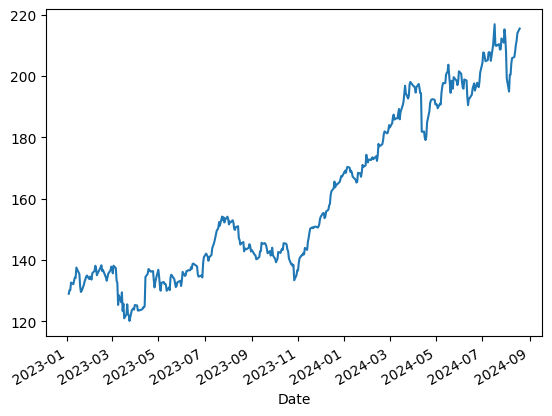

In [5]:
# Plot it
data['Adj Close'].plot()

In [6]:
# We now do feature engineering
# Daily Variation, to account for volatility
data['Daily Variation'] = (data['High'] - data['Low']) / data['Open']
# Daily return, to account for performance
data['Daily Return'] = data['Close'].pct_change()
# 7-day SMA, to account for short term trend
data['7 Day SMA'] = data['Close'].rolling(window=7).mean()
# 7-day STD, to account for short term variability
data['7 Day STD'] = data['Close'].rolling(window=7).std()
# SMA + 2*STD, to account for the upper bound of a confidence interval for the index
data['SMA+2*STD'] = data['7 Day SMA'] + 2 * data['7 Day STD']
# SMA - 2*STD, to account for the lower bound of a confidence interval for the index
data['SMA-2*STD'] = data['7 Day SMA'] - 2 * data['7 Day STD']
# High - Close, to account for downward pressure on the index
data['High - Close'] = (data['High'] - data['Close'])/data['Open']
# Low - Open, to account for upward pressure on the index
data['Low - Open'] = data['Low'] - data['Open']/data['Open']
# Cumulative Return, to account for long term performance
data['Cumulative Return'] = (1 + data['Daily Return']).cumprod() - 1
# 14 day EMA
data['14 Day EMA'] = data['Close'].ewm(span=14).mean()
# Close % Change
data['Close % Change'] = data['Close'].pct_change()
# Close Change
data['Close Change'] = data['Close'] - data['Close'].shift(1)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Variation,Daily Return,7 Day SMA,7 Day STD,SMA+2*STD,SMA-2*STD,High - Close,Low - Open,Cumulative Return,14 Day EMA,Close % Change,Close Change
Date,,,,,,,,,,,,,,,,,,
2023-01-03,135.240005,136.740005,133.889999,135.119995,128.934052,11054800,0.021074,NaN,NaN,NaN,NaN,NaN,0.011979,132.889999,NaN,135.119995,NaN,NaN
2023-01-04,135.990005,137.679993,135.570007,136.380005,130.136383,11687600,0.015516,0.009325,NaN,NaN,NaN,NaN,0.009559,134.570007,0.009325,135.795000,0.009325,1.260010
2023-01-05,135.660004,135.710007,133.699997,135.350006,130.107559,8381300,0.014817,-0.007552,NaN,NaN,NaN,NaN,0.002654,132.699997,0.001702,135.625011,-0.007552,-1.029999
2023-01-06,136.130005,138.380005,134.490005,137.940002,132.597214,10029100,0.028576,0.019136,NaN,NaN,NaN,NaN,0.003232,133.490005,0.020870,136.333232,0.019136,2.589996
2023-01-09,138.600006,138.880005,136.880005,137.369995,132.049301,8482300,0.014430,-0.004132,NaN,NaN,NaN,NaN,0.010895,135.880005,0.016652,136.603722,-0.004132,-0.570007


In [18]:
# Look at the mutual information to determine which features are relevant

# Separate the target variable and features
Features = data.drop('Adj Close', axis=1).fillna(method='ffill').dropna(axis=1)
Targets = data['Adj Close']

# Calculate mutual information for each feature
mutual_info = mutual_info_regression(Features, Targets)

# Create a DataFrame to store the results
mi_df = pd.DataFrame({'Feature': Features.columns, 'MI Score': mutual_info})

# Sort the DataFrame by MI score in descending order
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Print the results
print(mi_df)


           Feature  MI Score
3            Close  3.680739
7       Low - Open  2.833484
2              Low  2.832901
1             High  2.718132
0             Open  2.404631
8       14 Day EMA  2.061632
4           Volume  0.110834
5  Daily Variation  0.051794
6     High - Close  0.000000


<ipython-input-18-19f39fc804ed>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Features = data.drop('Adj Close', axis=1).fillna(method='ffill').dropna(axis=1)


In [22]:
# Create our Features dataframe of the most relevant variables
X = Features[['Close', 'Low - Open', 'Low', 'High', 'Open','14 Day EMA', 'Volume','Daily Variation']]
X.head()

,Close,Low - Open,Low,High,Open,14 Day EMA,Volume,Daily Variation
Date,,,,,,,,
2023-01-03,135.119995,132.889999,133.889999,136.740005,135.240005,135.119995,11054800,0.021074
2023-01-04,136.380005,134.570007,135.570007,137.679993,135.990005,135.795000,11687600,0.015516
2023-01-05,135.350006,132.699997,133.699997,135.710007,135.660004,135.625011,8381300,0.014817
2023-01-06,137.940002,133.490005,134.490005,138.380005,136.130005,136.333232,10029100,0.028576
2023-01-09,137.369995,135.880005,136.880005,138.880005,138.600006,136.603722,8482300,0.014430


In [24]:
# Create a list of actions (Buy or sell depending on whether or not the stock will rise or fall)
Prices = data['Adj Close']
Adj_shifted = Prices.shift(1)
Actions = []
for i in range(1, len(Prices)):
  if Prices[i] > Adj_shifted[i]:
    Actions.append('Buy')
  else:
    Actions.append('Sell')

Actions.insert(0, '')
Y = pd.DataFrame(Actions, columns=['Signal'])
Y.index = data.index
print(Y)

           Signal
Date             
2023-01-03       
2023-01-04    Buy
2023-01-05   Sell
2023-01-06    Buy
2023-01-09   Sell
...           ...
2024-08-13    Buy
2024-08-14    Buy
2024-08-15    Buy
2024-08-16    Buy
2024-08-19    Buy

[409 rows x 1 columns]


<ipython-input-24-267a9a406691>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Prices[i] > Adj_shifted[i]:


In [25]:
# Convert to numpy , note we don't need to scale here as random forests are invariant to scaling
x = np.array(X)

In [36]:
# Do a train, test split but don't shuffle the data
X_train, X_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.2,random_state=None, shuffle=False)

In [37]:
# Review the dimensions of the training and testing data
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(327, 8) (82, 8) (327, 1) (82, 1)


In [38]:
# Define the class for Blocking Time Series Split
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
    self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
    return self.n_splits

  def split(self, X, y=None, groups=None):
    n_samples = len(X)
    k_fold_size = n_samples // self.n_splits
    indices = np.arange(n_samples)

    margin = 0
    for i in range(self.n_splits):
      start = i * k_fold_size
      stop = start + k_fold_size
      mid = int(0.5 * (stop - start)) + start
      yield indices[start: mid], indices[mid + margin: stop]

In [40]:
# We use a random forest classifier to fit the features onto the targets, we use Grid Search to determine the best fit
parameters = {'n_estimators':[1,5, 10, 20, 50, 100],'max_depth':[1,5,10,20,50,100],'min_samples_leaf':[1,5,10,20,50,100]}
RandomForest = RandomForestClassifier()
grid = GridSearchCV(RandomForest, parameters, cv=BlockingTimeSeriesSplit(n_splits=5))
grid.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

GridSearchCV(cv=<__main__.BlockingTimeSeriesSplit object at 0x7ad26c569870>,
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 20, 50, 100],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'n_estimators': [1, 5, 10, 20, 50, 100]})

In [41]:
print("\n, The best parameters across all searched parameters:\n", grid.best_params_)


, The best parameters across all searched parameters:
 {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}


In [49]:
# Fit our optimised model onto the data and use it to predict the testing data
model = RandomForestClassifier(max_depth=5, min_samples_leaf=1, n_estimators=10)
model.fit(X_train, Y_train)
preds = model.predict(X_test)
preds

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell',
       'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell',
       'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell',
       'Sell', 'Buy', 'Buy', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Sell',
       'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Buy',
       'Sell', 'Buy', 'Sell', 'Sell', 'Buy'], dtype=object)

In [48]:
# Devise performance metrics for the test data
# Get the predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob, pos_label='Buy')
roc_auc = auc(fpr, tpr)

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(Y_test, model.predict(X_test))

# Calculate the F1-score
f1 = f1_score(Y_test, model.predict(X_test), pos_label='Buy')

# Print the results
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1-Score: {f1:.4f}")


ROC AUC: 0.5176
Balanced Accuracy: 0.5263
F1-Score: 0.3125


In [51]:
# We can now backtest our data
def trading_strategy(Y_df, data):
  # Initialize variables
  position = 0
  buy_price = 0
  returns = []

  # Iterate through the signals and execute trades
  for index, row in Y_df.iterrows():
    if row['Action'] == 'Buy' and position == 0:
      position = 1
      buy_price = data.loc[index, 'Adj Close']
    elif row['Action'] == 'Sell' and position == 1:
      position = 0
      sell_price = data.loc[index, 'Adj Close']
      returns.append((sell_price - buy_price) / buy_price)

  # Calculate total return
  total_return = (1 + np.array(returns)).prod() - 1

  return returns, total_return

In [57]:
# Use the trading function to determine the returns of the recommendations from the model
Predictions = pd.DataFrame(preds, columns=['Action'])
Predictions.index = Y_test.index
returns, total_return = trading_strategy(Predictions, data)
print(f"Returns: {returns}")

Returns: [-0.0020297544530543223, 0.015946878557680566, 0.002977526130732775, -0.04497286651039371, -0.0060645872155653075, -0.006028630605983559, -0.013180127008662501, 0.013711838206979158, 0.028559455660328765, -0.01192929814896779, 0.015771794032088716, -0.013250530719689277, 0.002383449341736505, 0.009080985334862332, -0.022744343366919162, 0.02791176301573182, 0.01901403964144612, 0.006230962349534111]


In [64]:
# Create a function to get the metrics for the trades
def calculate_metrics(returns):

  # Calculate cumulative returns
  cumulative_returns = (1 + np.array(returns)).cumprod()

  # Calculate maximum drawdown
  peak = cumulative_returns.max()
  drawdown = (cumulative_returns / peak) - 1
  max_drawdown = drawdown.min()

  # Calculate Sharpe ratio
  avg_return = np.mean(returns)
  std_dev = np.std(returns)
  sharpe_ratio = avg_return / std_dev if std_dev else 0.0

  # Calculate Calmar ratio
  calmar_ratio = avg_return / abs(max_drawdown) if max_drawdown else 0.0


  # Calculate relative drawdown
  average_drawdown = np.mean(drawdown)
  relative_drawdown = average_drawdown / avg_return if avg_return else 0.0

  return {
      'max_drawdown': max_drawdown,
      'sharpe_ratio': sharpe_ratio,
      'calmar_ratio': calmar_ratio,
      'relative_drawdown': relative_drawdown
  }


In [65]:
# Get the metrics
metrics = calculate_metrics(returns)
for metric, value in metrics.items():
  print(f"{metric}: {value:.4f}")


max_drawdown: -0.0705
sharpe_ratio: 0.0658
calmar_ratio: 0.0169
relative_drawdown: -28.1212
